In [22]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam_models.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from cam_models.utils.visualize import visualize, reverse_normalize

from dataset.dataset import TestDataset
from utils.transforms import get_transform
from config import config, model_conv, device
import os

In [23]:
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
test_data = TestDataset(
    root="data/images/images",
    img_list="data/sample_sub_v2.csv",
    transforms=get_transform(mode="explain"),
)
len(test_data)

509

In [25]:
test_data_visualize = TestDataset(
    root="data/images/images",
    img_list="data/sample_sub_v2.csv",
    transforms=None,
)
len(test_data_visualize)

509

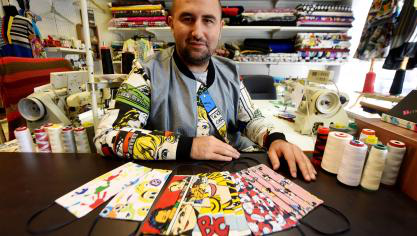

In [27]:
test_data_visualize[1]

tensor([[[-1.1075, -0.9877, -0.8678,  ..., -1.7754, -1.8097, -1.7412],
         [-1.0733, -0.9877, -0.8678,  ..., -1.5014, -1.6727, -1.6555],
         [-1.1589, -1.0562, -0.9192,  ..., -1.1075, -1.2788, -1.2788],
         ...,
         [-0.5253, -0.5082, -0.4226,  ..., -1.7754, -1.4672, -1.0904],
         [-0.3369, -0.4226, -0.4911,  ..., -2.0152, -1.8782, -1.7069],
         [-0.5253, -0.8849, -0.6452,  ..., -2.1179, -2.1179, -2.0837]],

        [[-1.0728, -0.9503, -0.8102,  ..., -1.5805, -1.5980, -1.5455],
         [-1.0378, -0.9328, -0.7927,  ..., -1.3704, -1.5455, -1.5280],
         [-1.1078, -0.9678, -0.8277,  ..., -1.0553, -1.2304, -1.2304],
         ...,
         [-0.0574, -0.0574,  0.0301,  ..., -1.8431, -1.5455, -1.1253],
         [ 0.1352,  0.0126, -0.0749,  ..., -1.9657, -1.8081, -1.6506],
         [ 0.1352, -0.3550, -0.1800,  ..., -1.9832, -1.9482, -1.9307]],

        [[-0.9678, -0.8981, -0.8110,  ..., -1.6476, -1.6824, -1.6127],
         [-0.9504, -0.8981, -0.8284,  ..., -1

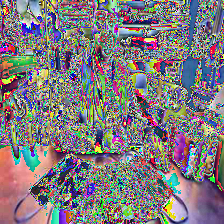

In [28]:
print(test_data[0])
print(len(test_data))
# print(test_data[0][0].shape)
# img = test_data[1]
print(test_data[0])
# print(img.shape)
img = test_data[1]
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [29]:
tensor_img = img.unsqueeze(0)
tensor_img.shape

torch.Size([1, 3, 224, 224])

In [30]:
print(os.path.join(config["model"]["saved_models_folder"],config["model"]["saved_model"]))

saved_models\resnet50_06282022-18-30.pth


In [31]:
load_flag = config["model"]["load_trained_model"]
if load_flag:
    model_conv.load_state_dict(
        torch.load(
            os.path.join(
                config["model"]["saved_models_folder"],
                config["model"]["saved_model"],
            )
        )
    )

In [32]:
# # Load model from previous training
# load_flag = True
# if load_flag:
#     model_conv.load_state_dict("saved_models/resnet50_06282022-18-30.pth")

print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
model_conv.eval()
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
# the target layer you want to visualize
model_conv.cpu()
target_layer = model_conv.layer4[1].conv2

# wrapper for class activation mapping. Choose one of the following.
# wrapped_model = CAM(model, target_layer)
# wrapped_model =GradCAM(model, target_layer)
# wrapped_model = GradCAMpp(model, target_layer)
wrapped_model = SmoothGradCAMpp(model_conv, target_layer, n_samples=25, stdev_spread=0.15)

In [35]:
tensor_img

tensor([[[[ 0.1768,  0.4851,  0.6221,  ..., -1.7240, -0.4054,  1.4440],
          [ 0.1768,  0.3309,  0.6734,  ..., -1.5870, -0.2513,  1.4954],
          [ 0.3823,  0.2624,  0.6392,  ..., -1.6042,  0.0741,  1.6667],
          ...,
          [-1.4329, -1.4329, -1.4329,  ..., -1.6213, -1.6555, -1.6727],
          [-1.4500, -1.4500, -1.4500,  ..., -1.6213, -1.6555, -1.6727],
          [-1.4500, -1.4500, -1.4500,  ..., -1.6213, -1.6555, -1.6727]],

         [[ 0.0651,  0.3452,  0.4503,  ..., -1.5980, -0.1275,  1.8508],
          [ 0.0826,  0.2052,  0.4853,  ..., -1.4405,  0.0301,  1.8508],
          [ 0.2927,  0.1352,  0.5028,  ..., -1.4755,  0.3452,  1.9909],
          ...,
          [-1.6681, -1.6681, -1.6681,  ..., -1.7206, -1.7556, -1.7731],
          [-1.6506, -1.6506, -1.6506,  ..., -1.7206, -1.7556, -1.7731],
          [-1.6506, -1.6506, -1.6506,  ..., -1.7206, -1.7556, -1.7731]],

         [[-0.3404, -0.0964, -0.0267,  ..., -1.7870, -0.7238,  0.9319],
          [-0.3055, -0.2010,  

In [36]:
print(device)
tensor_img.cpu()
target_layer.cpu()
cam, idx = wrapped_model(tensor_img)

cuda


c:\Users\HP\anaconda3\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 1	 probability 0.5238174796104431


In [37]:
print(cam.shape)
# Image.fromarray(cam.squeeze().mul(255).permute(1, 2, 0).byte().numpy())

torch.Size([1, 1, 7, 7])


RuntimeError: number of dims don't match in permute

torch.Size([1, 1, 7, 7])


c:\Users\HP\anaconda3\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
c:\Users\HP\anaconda3\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
c:\Users\HP\anaconda3\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


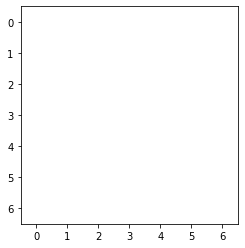

In [38]:
# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')
print(cam.shape)

In [39]:
# reverse normalization for display
img = reverse_normalize(tensor_img)
tensor_img

tensor([[[[0.5255, 0.5961, 0.6275,  ..., 0.0902, 0.3922, 0.8157],
          [0.5255, 0.5608, 0.6392,  ..., 0.1216, 0.4275, 0.8275],
          [0.5725, 0.5451, 0.6314,  ..., 0.1176, 0.5020, 0.8667],
          ...,
          [0.1569, 0.1569, 0.1569,  ..., 0.1137, 0.1059, 0.1020],
          [0.1529, 0.1529, 0.1529,  ..., 0.1137, 0.1059, 0.1020],
          [0.1529, 0.1529, 0.1529,  ..., 0.1137, 0.1059, 0.1020]],

         [[0.4706, 0.5333, 0.5569,  ..., 0.0980, 0.4275, 0.8706],
          [0.4745, 0.5020, 0.5647,  ..., 0.1333, 0.4627, 0.8706],
          [0.5216, 0.4863, 0.5686,  ..., 0.1255, 0.5333, 0.9020],
          ...,
          [0.0824, 0.0824, 0.0824,  ..., 0.0706, 0.0627, 0.0588],
          [0.0863, 0.0863, 0.0863,  ..., 0.0706, 0.0627, 0.0588],
          [0.0863, 0.0863, 0.0863,  ..., 0.0706, 0.0627, 0.0588]],

         [[0.3294, 0.3843, 0.4000,  ..., 0.0039, 0.2431, 0.6157],
          [0.3373, 0.3608, 0.4235,  ..., 0.0314, 0.2784, 0.6392],
          [0.4000, 0.3608, 0.4431,  ..., 0

torch.Size([1, 3, 224, 224])


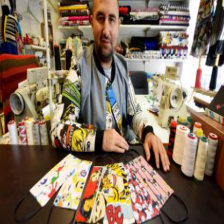

In [40]:
print(tensor_img.shape)
#Image.fromarray(tensor_img.squeeze().mul(255).permute(1, 2, 0).byte().numpy())
Image.fromarray(img.squeeze().mul(255).permute(1, 2, 0).byte().numpy())

In [41]:
heatmap = visualize(img, cam)
heatmap

tensor([[[[0.3499, 0.3969, 0.4178,  ..., 0.0601, 0.2611, 0.5431],
          [0.3499, 0.3734, 0.4256,  ..., 0.0809, 0.2846, 0.5509],
          [0.3812, 0.3629, 0.4204,  ..., 0.0783, 0.3342, 0.5770],
          ...,
          [0.1044, 0.1044, 0.1044,  ..., 0.0757, 0.0705, 0.0679],
          [0.1018, 0.1018, 0.1018,  ..., 0.0757, 0.0705, 0.0679],
          [0.1018, 0.1018, 0.1018,  ..., 0.0757, 0.0705, 0.0679]],

         [[0.3133, 0.3551, 0.3708,  ..., 0.0653, 0.2846, 0.5796],
          [0.3159, 0.3342, 0.3760,  ..., 0.0888, 0.3081, 0.5796],
          [0.3473, 0.3238, 0.3786,  ..., 0.0836, 0.3551, 0.6005],
          ...,
          [0.0548, 0.0548, 0.0548,  ..., 0.0470, 0.0418, 0.0392],
          [0.0574, 0.0574, 0.0574,  ..., 0.0470, 0.0418, 0.0392],
          [0.0574, 0.0574, 0.0574,  ..., 0.0470, 0.0418, 0.0392]],

         [[0.5535, 0.5901, 0.6005,  ..., 0.3368, 0.4961, 0.7441],
          [0.5587, 0.5744, 0.6162,  ..., 0.3551, 0.5196, 0.7598],
          [0.6005, 0.5744, 0.6292,  ..., 0

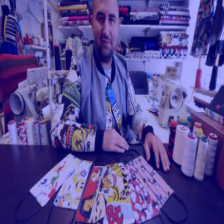

In [42]:
#hm = (heatmap.squeeze().numpy().transpose(1, 2, 0)).astype(np.int32)
#imshow(hm)
Image.fromarray(heatmap.squeeze().mul(255).permute(1, 2, 0).byte().numpy())